In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick

# Basic Data Exploration

Since the dataset is relatively small I performed some basic checks on data_types, missing values, and unique values.

In [56]:
event_data = pd.read_csv("data/the_event_data.csv", dtype = object)

In [57]:
event_data.head()

,event_id,user_id,event_type,timestamp
0,41486276,1331979,PhotoNameManuallyCreated,2018-11-26 22:18:02
1,41486371,1534809,AccountDeleted,2018-11-26 22:18:50
2,41485779,697740,PhotoNameSuggested,2018-11-26 22:13:07
3,41485798,911751,PhotoNameSuggested,2018-11-26 22:13:21
4,41485258,1209480,PhotoNameSuggested,2018-11-26 22:08:33


In [58]:
event_data.shape

(1225133, 4)

In [59]:
event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225133 entries, 0 to 1225132
Data columns (total 4 columns):
event_id      1225133 non-null object
user_id       1224626 non-null object
event_type    1225133 non-null object
timestamp     1225133 non-null object
dtypes: object(4)
memory usage: 37.4+ MB


In [60]:
print("Min: {}, Max: {}".format(event_data['timestamp'].min(),event_data['timestamp'].max()))

Min: 2018-05-31 00:00:03, Max: 2018-12-31 23:59:54


Can't easily tell from the info call if user_id contains any nulls, so I check manually.

In [61]:
event_data['user_id'].isna().sum()

507

Check if any users do not have an AccountCreated event in the dataset.

In [62]:
event_data['user_id'].nunique()

76945

In [63]:
event_data.loc[event_data['event_type'] == 'AccountCreated']['user_id'].nunique()

31601

In [64]:
event_data.event_type.value_counts()

PhotoNameSuggested             981051
PhotoNameSuggestionAccepted    141677
PhotoNameManuallyCreated        59536
AccountCreated                  31601
AccountDeleted                  11268
Name: event_type, dtype: int64

# Create schema

## ETL contained in python script.

# Read in data
Reading in data from the Postgres database.

1. <b>events</b>: All rows from the provided event table.
2. <b>users</b>: All rows from the user_activty table.
2. <b>at_least_one_suggestion</b>: Users from the user_activity table that are associated to at least one event of type 'PhotoNameSuggested.
3. <b>no_suggestions</b>: Users from the user_activity table where the user_id is not in the list of distinct user_id's from the events table where the event_type is 'PhotoNameSuuggested'.

In [65]:
import psycopg2
import pguser as credentials
import pandas.io.sql as psql

conn_string = "host={} port=5432 dbname={} user={} password={}".format(credentials.PGHOST, credentials.PGDATABASE,
                                                                credentials.PGUSER, credentials.PGPASSWORD)
connection = psycopg2.connect(conn_string)

users =  psql.read_sql("SELECT * FROM user_activity", connection)


at_least_one_suggestion = psql.read_sql('''select distinct(user_activity.user_id)
                                            from user_activity
                                            join events on events.user_id  = user_activity.user_id
                                            where event_type = 'PhotoNameSuggested'
                                            group by user_activity.user_id
                                            having count(*) >= 1;''', connection)

no_suggestions = psql.read_sql('''select *
                                from user_activity
                                where user_id not in 
                                (select distinct user_id from events where event_type = 'PhotoNameSuggested');''',
                               connection)

\* Need to cast the date variables to datetime data type for visualizations later on.

In [66]:
users['activation_date'] = pd.to_datetime(users['activation_date'])
users['created_date'] = pd.to_datetime(users['created_date'])

## Aggregating the data

Need to select several subsets of data. These datasets build upon the events and the users datasets above.

1. <b>first_week_activation:</b> Selecting from the dataset of users where the difference between the activation date and account created date is 7 days or less
2. <b>first_week_one_plus_suggestion</b>: The intersection of users who were active in a week of the account creation date and users who have had at least one photo name suggested.
3. <b>first_week_no_suggestion</b>: Contains users who were active in a week of the account creation date who are not associated with a PhotoNameSuggested event type.

In [67]:
first_week_activation = users.loc[((users['activation_date'] - 
                                           users['created_date']).dt.days <= 7)]

first_week_one_plus_suggestion = first_week_activation.merge(at_least_one_suggestion)
first_week_no_suggestion = first_week_activation.merge(no_suggestions)

# First Visualization
### Group and prepare data for the first visualization
To prepare the data for visualization we need to set the index to the 'created_date' so we can group by week and calculate the percentages. Then we can drill down to week, get counts, and calculate the percentages

In [68]:
all_users_aggregated = users.set_index('created_date')[['user_id']].resample('W').count()


first_week_activation.index = first_week_activation['created_date'] 
first_week_counts = first_week_activation[['user_id']].resample('W').count()\
.merge(all_users_aggregated, on = 'created_date')
first_week_counts['percent'] = first_week_counts['user_id_x']/first_week_counts['user_id_y'] * 100



first_week_one_plus_suggestion.index = first_week_one_plus_suggestion['created_date'] 
first_week_one_plus_suggestion_counts = first_week_one_plus_suggestion[['user_id']].resample('W').count()\
.merge(all_users_aggregated, on = 'created_date')
first_week_one_plus_suggestion_counts['percent'] = first_week_one_plus_suggestion_counts['user_id_x']/first_week_one_plus_suggestion_counts['user_id_y'] * 100


first_week_no_suggestion.index = first_week_no_suggestion['created_date'] 
first_week_no_suggestions = first_week_no_suggestion[['user_id']].resample('W').count()\
.merge(all_users_aggregated, on = 'created_date')
first_week_no_suggestions['percent'] = first_week_no_suggestions['user_id_x']/first_week_no_suggestions['user_id_y'] * 100

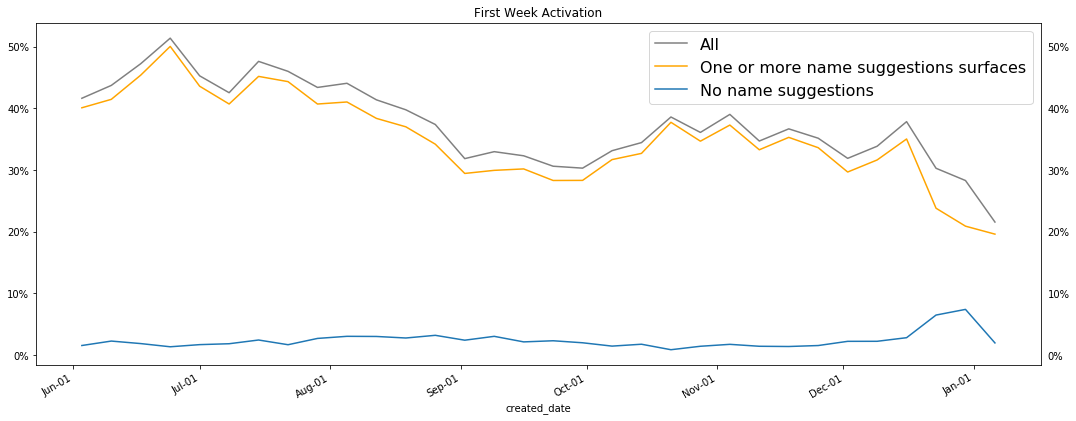

In [69]:
fig, ax = plt.subplots(figsize=(18,7))
ax.tick_params(labeltop=False, labelright=True)
ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('First Week Activation')

first_week_counts.plot(y = 'percent', kind='line', x_compat=True, label = 'All', color = 'grey', ax = ax)


first_week_one_plus_suggestion_counts.plot(y = 'percent', kind='line', 
                                           x_compat=True, label = 'One or more name suggestions surfaces',
                                           color = 'orange', ax=ax)

first_week_no_suggestions.plot(y = 'percent', kind='line', x_compat=True, label='No name suggestions', ax = ax)

plt.legend(prop={'size': 16})

# Second Visualization
### Group and prepare data for the second visualization
The second visualization is a percent stacked area chart, which requires some different operations. We will be comparing these two subsets of data to each other. In order to do this we need to normalize the data so the percentages add to 100%.

In [70]:
first_week_one = first_week_one_plus_suggestion[['user_id']].resample('W').count().rename(columns={'user_id': 'oneplus'})
first_week_no = first_week_no_suggestion[['user_id']].resample('W').count().rename(columns={'user_id': 'zero'})

combined_suggestion_data = pd.concat([first_week_one, first_week_no], axis=1)

suggestion_perc = combined_suggestion_data.divide(combined_suggestion_data.sum(axis=1), axis=0)


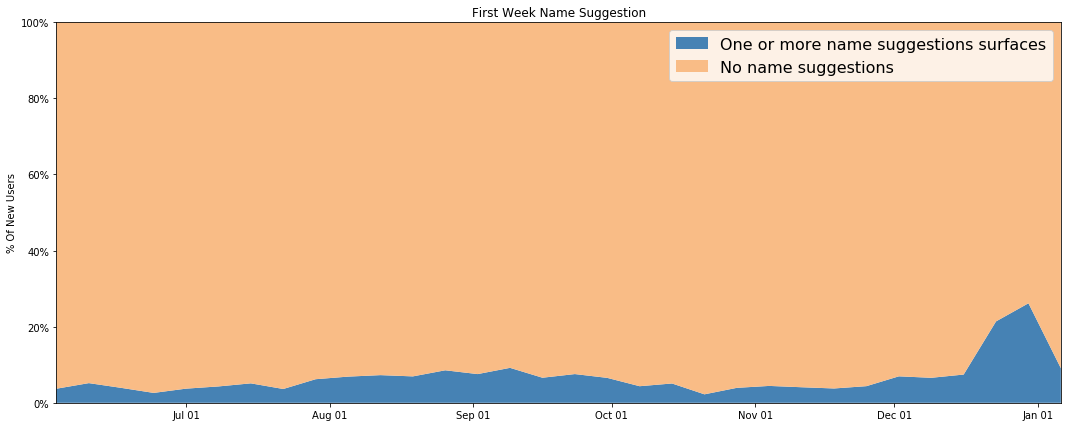

In [71]:
fig, ax = plt.subplots(figsize=(18,7))
plt.title('First Week Name Suggestion')
plt.ylabel('% Of New Users')

plt.stackplot(suggestion_perc.index,  suggestion_perc["zero"], suggestion_perc["oneplus"],
              labels=['One or more name suggestions surfaces','No name suggestions'], colors=['#4682b4', '#f9bc86'])

plt.margins(0,0)
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(prop={'size': 16})

### Another visualization

A 100% stack bar graph can also be used to present the above data if you reduce the bins to be grouped by month. Both are controversial because they can be hard to read. In this case I think with only two categories the stacked bar graph is easier to read.

In [72]:
first_week_one = first_week_one_plus_suggestion[['user_id']].resample('M').count().rename(columns={'user_id': 'oneplus'})
first_week_no = first_week_no_suggestion[['user_id']].resample('M').count().rename(columns={'user_id': 'zero'})

combined_suggestion_data = pd.concat([first_week_one, first_week_no], axis=1)

suggestion_perc = combined_suggestion_data.divide(combined_suggestion_data.sum(axis=1), axis=0)

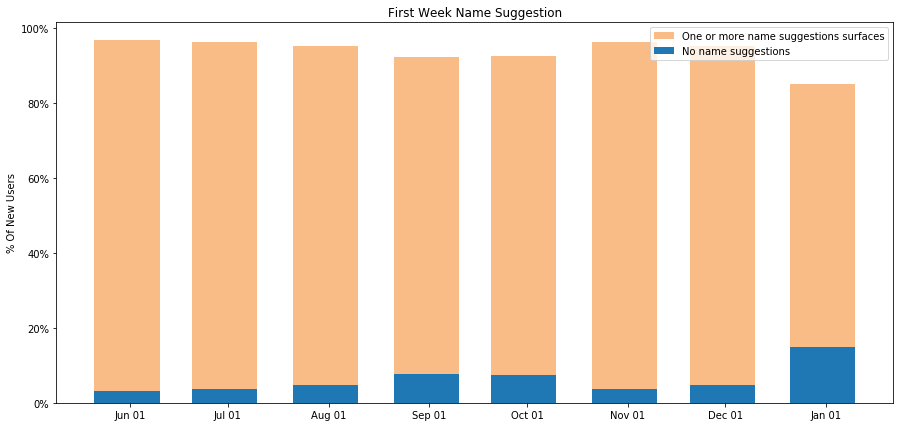

In [73]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title('First Week Name Suggestion')
plt.ylabel('% Of New Users')

plt.bar(suggestion_perc.index, suggestion_perc['oneplus'],label='One or more name suggestions surfaces',
        color='#f9bc86', width=20)
plt.bar(suggestion_perc.index, suggestion_perc['zero'],label='No name suggestions', width=20)
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(prop={'size': 10})